In [ ]:
# dataset @ https://finance.yahoo.com/quote/MSFT/history/

# If you want the exact same dataset as the YouTube video,
# use this link: https://drive.google.com/file/d/1WLm1AEYgU28Nk4lY4zNkGPSctdImbhJI/view?usp=sharing

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

MessageError: ignored

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
from dateutil.relativedelta import relativedelta
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN,Conv1D,GRU,MaxPooling1D,Bidirectional
from keras.layers import Dropout
from tensorflow.keras import layers

df1 = pd.read_csv('/content/gdrive/MyDrive/FPT/VIC.csv')
df1


Phân tích biến động giá cổ phiếu dựa trên giá close cuối ngày

In [ ]:
df1 = df1[['Date/Time', 'Close']]


In [ ]:
df1['Date/Time']

In [ ]:
import datetime

def str_to_datetime(s):
  split = s.split('-')
  
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

datetime_object = str_to_datetime('1986-03-19')
datetime_object

In [ ]:


def str_to_datetime1(s):
  sp = s.split(' ')[0]
  sp1 = s.split(' ')[1]

  split = sp.split('/')
  split1 = sp1.split(':')
 
  year, month, day,hour,minute = int(split[2]), int(split[0]), int(split[1]), int(split1[0]), int(split1[1])
  return datetime.datetime(year=year, month=month, day=day,hour=hour,minute=minute)

datetime_object1 = str_to_datetime1('12/25/2018 9:15')
datetime_object1

In [ ]:
df1

In [ ]:
df1['Date/Time'] = df1['Date/Time'].apply(str_to_datetime1)
df1['Date/Time']

In [ ]:
df1.index = df1.pop('Date/Time')
df1

In [ ]:

plt.plot(df.index, df['Close'])

In [ ]:


def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime1(first_date_str)
  last_date  = str_to_datetime1(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    # print(len(df_subset))
    assert len(df_subset) == n+1
 

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]
    # print(x,y)
    dates.append(target_date)
    X.append(x)
    Y.append(y)
    
    next = dataframe.loc[target_date:target_date+datetime.timedelta(hours=1,days=1)+relativedelta(years=1)]
    # print("next_week",next_week)
    next_datetime_str = str(next.head(2).tail(1).index.values[0])
    # print("next_datetime_str",next_week.head(2),"|",next_week.head(2).tail(1),"|",next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    next_hour_str = next_datetime_str.split('T')[1]
    # print("next_hour_str",next_hour_str)
    # print("next_date_str",next_date_str)
    hour_minute= next_hour_str.split(':')
    year_month_day = next_date_str.split('-')
    hour,minute,sc= hour_minute
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year),hour=int(hour),minute=int(minute))
    # print(next_date)
    if last_time:
      break
    # time.sleep(0.1)
    target_date = next_date
    
    if target_date == last_date:
      last_time = True
    # time.sleep(0.001)
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df

windowed_df = df_to_windowed_df(df1, 
                                '10/17/2018 9:53', 
                                '12/22/2020 14:46', 
                                n=10)
windowed_df

In [ ]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()
  
  dates = df_as_np[:,0]
 
  middle_matrix = df_as_np[:, 1:-1]

  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))
  
  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

In [ ]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)
q_80, q_90, int(len(dates))

In [ ]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])


> CNN chủ yếu được tạo thành từ hai phần: convolution layer và pooling layer


*   Một mạng neural tích chập 1D (CNN) với ba lớp tích chập, mỗi lớp có kernel_size là 3 và hàm kích hoạt ReLU, phần này của mô hình được thiết kế để học trích xuất dữ liệu ( extract feature ) tuy nhiên thì kích thước của feature sau khi đc trích xuất rất lớn nên để giải quyết vấn đề này thì lớp pooling được thêm vào để giải quyết vấn đề nêu trên 
*  Một LSTM layer với Unit =100 , là loại của RNN. Lớp này được thiết kế để giải quyết các vấn đề về sự bùng nổ độ dốc ( gradient explosion ) và biến mất độ dốc (vanish gradient) activation function được sử dụng đó là relu 



In [ ]:

def Regressor():
    regressor = Sequential()
    
    regressor.add( Conv1D(64,kernel_size=3, activation='relu',input_shape = (X_train.shape[1],1))) 
    regressor.add( Conv1D(128,kernel_size=3, activation='relu'))
    regressor.add( Conv1D(64,kernel_size=3, activation='relu'))
    regressor.add( MaxPooling1D(2))

   
    regressor.add(layers.LSTM(100, return_sequences=False))

    regressor.add(Dense(32,activation='relu'))
    regressor.add(Dense(32,activation='relu'))
    regressor.add(Dense(1))
    
    regressor.compile(
        optimizer = Adam(learning_rate=0.001), 
        loss = "mse",
        metrics = ["mean_absolute_error"])
    return regressor
model= Regressor()
model.summary()



Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_37 (Conv1D)          (None, 8, 64)             256       
                                                                 
 conv1d_38 (Conv1D)          (None, 6, 128)            24704     
                                                                 
 conv1d_39 (Conv1D)          (None, 4, 64)             24640     
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 2, 64)            0         
 g1D)                                                            
                                                                 
 lstm_1 (LSTM)               (None, 100)               66000     
                                                                 
 dense_7 (Dense)             (None, 32)                3232      
                                                     

In [ ]:
checkpoint_path = "/content/gdrive/MyDrive/FPT/tensorflow/VIC.h5"
# model.save(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,monitor='val_loss',
                                                  mode='min',
                                                  save_best_only=True)
# model.load_weights(checkpoint_path)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),epochs = 50, batch_size = 2247, callbacks=[cp_callback])

Epoch 1/50
34/37 [==========================>...] - ETA: 0s - loss: 106.5699 - mean_absolute_error: 9.3823
Epoch 1: val_loss improved from inf to 62.95135, saving model to /content/gdrive/MyDrive/FPT/tensorflow/VIC.h5
37/37 [==============================] - 1s 13ms/step - loss: 105.3004 - mean_absolute_error: 9.3254 - val_loss: 62.9514 - val_mean_absolute_error: 7.6539
Epoch 2/50
32/37 [========================>.....] - ETA: 0s - loss: 64.9649 - mean_absolute_error: 7.2697
Epoch 2: val_loss did not improve from 62.95135
37/37 [==============================] - 0s 10ms/step - loss: 62.7194 - mean_absolute_error: 7.1343 - val_loss: 66.6863 - val_mean_absolute_error: 8.0485
Epoch 3/50
36/37 [============================>.] - ETA: 0s - loss: 25.8269 - mean_absolute_error: 4.4317
Epoch 3: val_loss improved from 62.95135 to 28.79088, saving model to /content/gdrive/MyDrive/FPT/tensorflow/VIC.h5
37/37 [==============================] - 0s 10ms/step - loss: 25.8193 - mean_absolute_error: 4.43

DỰ ĐOÁN BIẾN ĐỘNG TRÊN LƯỢNG DATA ĐÃ TRAIN

---



2532/2532 [==============================] - 10s 4ms/step
[[[98.6]
  [98.6]
  [98.7]
  ...
  [98.8]
  [98.7]
  [98.6]]

 [[98.6]
  [98.7]
  [98.7]
  ...
  [98.7]
  [98.6]
  [98.6]]

 [[98.7]
  [98.7]
  [98.8]
  ...
  [98.6]
  [98.6]
  [98.6]]

 ...

 [[86.6]
  [86.8]
  [86.7]
  ...
  [87. ]
  [87. ]
  [87. ]]

 [[86.8]
  [86.7]
  [87. ]
  ...
  [87. ]
  [87. ]
  [86.8]]

 [[86.7]
  [87. ]
  [86.8]
  ...
  [87. ]
  [86.8]
  [86.8]]]
[98.7234   98.71632  98.70064  ... 86.87515  86.95     86.990395]


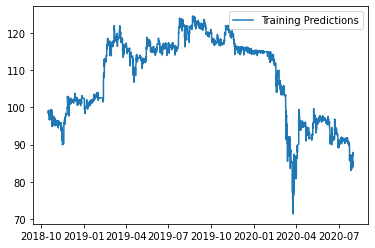

In [ ]:
model.load_weights(checkpoint_path)
train_predictions = model.predict(X_train).flatten()
print(X_train)
print(train_predictions)
plt.plot(dates_train, train_predictions)
# plt.plot(dates_train, y_train)
plt.legend(['Training Predictions','Training Observation'])


[98.6 98.6 98.5 ... 86.8 86.8 86.8]


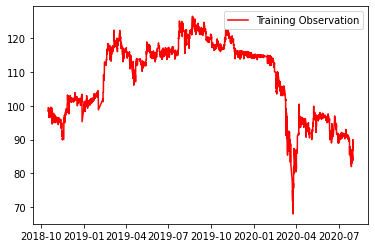

In [ ]:
plt.plot(dates_train, y_train,'r')
print(y_train)
plt.legend(['Training Observation'])

DỰ ĐOÁN TRÊN LƯỢNG DATA VALIDATION


---



281/281 [==============================] - 1s 3ms/step


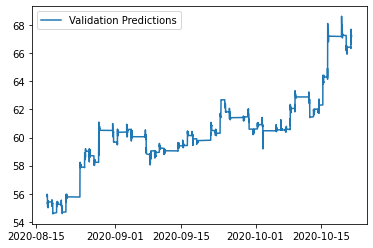

In [ ]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
# plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions'])

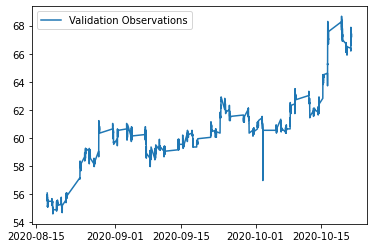

In [ ]:
plt.plot(dates_val, y_val)
plt.legend([ 'Validation Observations'])

In [ ]:
X_test[0]

array([[67.09],
       [67.19],
       [67.28],
       [67.19],
       [67.28],
       [67.19],
       [67.19],
       [67.28],
       [67.28],
       [67.38]], dtype=float32)

281/281 [==============================] - 1s 3ms/step


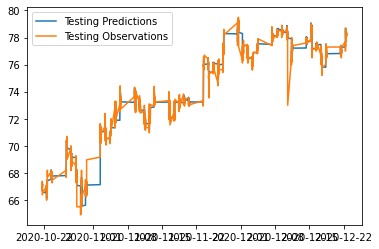

In [ ]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

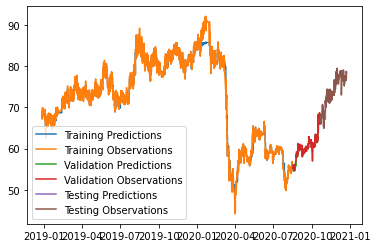

In [ ]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])